# 電波ポインティング解析

## 初期処理
- 以下の定数 (大文字の変数名のもの) を各自で設定すること
  - `sys.path` の操作については PyPl ではなくローカルのパッケージを使いたい時に使用すること

In [7]:
# ======================================================================
DATETIME = "20241031_024501"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
PLANET = "sun"  # 観測対象  e.g. "sun", "moon"
RAWDATA_PATH = f"/1p85m/ex_hdd01/v4/RawData/necst_radiopointing_{DATETIME}_{PLANET}"  # 観測データのパス
SPECTRAL_NAME = "xffts-board2"  # 解析に使用する分光データ
SAVE_PATH = f"./{DATETIME}_{PLANET}"# 解析結果の保存先

# RAWDATA_PATH = "/1p85m/ex_hdd01/v4/RawData/test_20241118_saturn"  # temp

BAD_CH = [  # スプリアスとして除外するチャンネル範囲
    (9000,9100), (10000, 13000), (15000, 16000),  # sprious
    (16000, 17000),  # center of ch
    (26000, 32767),  # approx. 2000-2500 MHz
]

PATH_NERCST = "/1p85m/nercst"
PATH_NECLIB = "/1p85m/neclib"
# ======================================================================
import pprint
import sys

if PATH_NERCST not in sys.path:
    sys.path.insert(0, PATH_NERCST)
if PATH_NECLIB not in sys.path:
    sys.path.insert(0, PATH_NECLIB)
pprint.pprint(sys.path)
# ======================================================================

['/1p85m/neclib',
 '/1p85m/nercst',
 '/usr/local/lib/python39.zip',
 '/usr/local/lib/python3.9',
 '/usr/local/lib/python3.9/lib-dynload',
 '',
 '/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages']


- 以降は設定不要

In [8]:
%matplotlib inline
import bisect
import math
from typing import List, Literal, Tuple

import nercst
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from astropy import constants as const
from astropy.convolution import Box1DKernel, convolve
from scipy import optimize
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import get_body, AltAz
from astropy import units as u
from neclib.coordinates import PointingError

from neclib import config
from neclib.core import Parameters

In [9]:
print(nercst.__path__)
import neclib
print(neclib.__path__)

['/1p85m/nercst/nercst']
['/1p85m/neclib/neclib']


In [10]:
def integ_exclude_sprious(db, exclude: List[Tuple[int, int]]) -> np.ndarray:
    """指定したスプリアス範囲を除いて total power を算出する"""
    # 軸の範囲を作成
    all_indices = np.arange(db.data.shape[1])  # shape[1] は ch の次元
    # 除外する範囲のマスクを作成
    mask = np.ones_like(all_indices, dtype=bool)  # すべて True に初期化
    for start, end in exclude:
        mask[start:end+1] = False  # 除外範囲を False に設定
    
    # マスクを適用して除外した範囲以外の和を計算
    integrated = np.sum(db.data[:, mask], axis=1)
    # 比較用
    integrated_full = np.sum(db.data, axis=1)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(integrated_full)
    ax.plot(integrated)
    ax.title.set_text(str(rawdata_path / spectral_name))
    ax.set_yscale("log")
    ax.set_xlabel("time index")
    ax.set_ylabel("total power")
    ax.legend(["full ch integrated", "excluded sprious ch"])

    return integrated

def gaussian_func(x, a, mu, sigma):
    """ガウス関数

    Parameters
    ----------
    x
        x座標。
    a
        振幅。
    mu
        中心位置を示す値。
    sigma
        標準偏差。
    """
    return a * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

def find_nearest_index(lst: List[float], target: float) -> int:
    """
    昇順に並んだ数値のリストの中で指定された数値に最も近い要素のインデックスを返す。
    
    Parameters
    ----------
    lst
        昇順に並んだ数値のリスト。
    target
        対象となる数値。この数値に最も近いリスト内の要素のインデックスを探す。
        
    Returns
    -------
    int
        `target`に最も近い要素のインデックス。
    
    Example
    -------
    >>> l = [0.5, 1.2, 3.4, 7.6, 8.9]
    >>> find_nearest_index(l, 3.1)
    2
    """
    pos = bisect.bisect_left(lst, target)
    
    if pos == 0:
        return 0
    if pos == len(lst):
        return len(lst) - 1
    
    before = pos - 1
    after = pos
    if abs(lst[after] - target) < abs(lst[before] - target):
        return after
    else:
        return before

def make_id_index(data) -> List[List[List[int]]]:
    id_index = []
    _id_index = []
    __id_index = []
    prev_cross = 0
    prev_axis = 0
    id_values = data.id.values
    # id_values = np.append(id.values, b"9999")  # 末尾のスキャンを処理するためのダミーが必要だが、既にIDデータ配列の末尾に9999が含まれているため不要

    for i, _x in enumerate(id_values):
        x = _x.decode().strip()
        if x == "":
            continue

        if "-" not in x:  # x: 9999 (final hot and off)
            _id_index.append(__id_index)
            id_index.append(_id_index)
            break

        if int(x[-1]) != prev_axis:  # axis: 0 (Az) or 1 (El)
            _id_index.append(__id_index)
            __id_index = []

        if int(x[:-2]) != prev_cross:  # cross_id: 0, 1, 2, ..., n-1
            id_index.append(_id_index)
            _id_index = []

        __id_index.append(i)
        prev_cross = int(x[:-2])
        prev_axis = int(x[-1])
    
    return id_index

def get_scan_range(cross_id: int, axis: int) -> Tuple[int, int, int]:
    """指定されたスキャンの始点、中点、終点のインデックスを順に返す。"""
    id_index = make_id_index(data)
    end = id_index[cross_id][axis][-1]
    scan_start_time = data.t[end] - one_scan_time.to(u.s).value
    scan_center_time = data.t[end] - one_scan_time.to(u.s).value / 2
    finded_start = find_nearest_index(data.t, scan_start_time)
    if finded_start >= id_index[cross_id][axis][0]:
        start = finded_start
        center = find_nearest_index(data.t, scan_center_time)
    else:
        # 推定されるスキャンの始点が見つからなかった場合、スキャンが中断された可能性がある
        start = id_index[cross_id][axis][0]
        center = (start + end) // 2
    return start, center, end

/1p85m/ex_hdd01/v4/RawData/necst_radiopointing_20241031_024501_sun
'sunscan_inf.toml' was found as the observation instruction file.


/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4523: RuntimeWarning: invalid value encountered in atoiq
  ri, di = ufunc.atoiq(type, ob1, ob2, astrom)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4620: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:19004: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
/1p85m/ex_hdd01/v4/nakagawa/.venv/lib/python3.9/site-packages/erfa/core.py:4036: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq

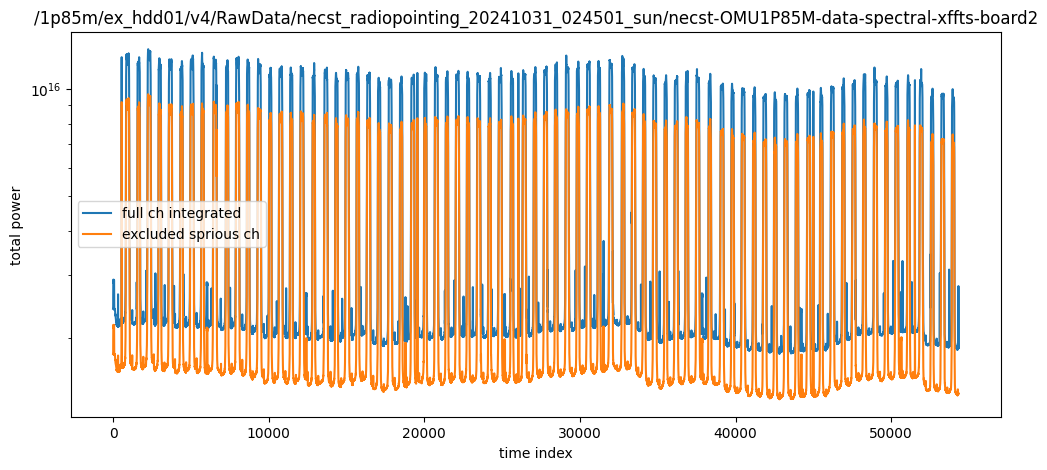

In [11]:
# パスの設定
rawdata_path = Path(RAWDATA_PATH)
spectral_name = Path(SPECTRAL_NAME)
save_path = Path(SAVE_PATH)
print(rawdata_path)

# 拡張子tomlの観測指示書の検索、読み込み、コピー
impl = rawdata_path.glob("*.toml")
for p in impl:
    if p.name.endswith("_config.toml"):
        shutil.copy(rawdata_path / p.name, rawdata_path / "config.toml")
    elif p.name not in ["config.toml", "device_setting.toml", "pointing_param.toml"]:
        shutil.copy(f"{rawdata_path / p.name}", f"{rawdata_path / p.name[:-5]}.obs")

obs_param = Parameters.from_file(rawdata_path.glob("*.obs")[0])
obs_speed = obs_param.speed
obs_radius_az = obs_param.max_separation_az
obs_radius_el = obs_param.max_separation_el
if obs_radius_az == obs_radius_el:
    one_scan_time = abs(obs_radius_az * 2 / obs_speed)
else:
    raise NotImplementedError()

# 観測データの読み込み
data = nercst.core.io.loaddb(str(rawdata_path), str(spectral_name))
data = nercst.core.multidimensional_coordinates.convert_frame(data, "altaz")

os.environ["NECST_ROOT"] = str(data.config_filepath.parent)
config.reload()

df = pd.DataFrame(columns=["time", "integrated", "lon", "lat", "lon_cor", "lat_cor"])
integrated = integ_exclude_sprious(db=data, exclude=BAD_CH)

df.integrated = integrated
df.lon = data.lon  # Az_enc
df.lat = data.lat  # El_enc
df.lon_cor = data.lon_cor  # Az_sky
df.lat_cor = data.lat_cor  # El_sky
df.time = data.t

pe = PointingError.from_file(data.config_filepath.parent / "pointing_param.toml")
t = Time(df.time, format="unix")
reference = get_body(PLANET, location=config.location, time=t)
press = data.pressure.values * u.hPa
temp = (data.temperature.values * u.K).to(u.deg_C, equivalencies=u.temperature())
humid = data.humidity.values
obswl = const.c / config.observation_frequency
altaz = AltAz(obstime=t, location=config.location, pressure=press, temperature=temp, relative_humidity=humid, obswl=obswl)
reference_altaz = reference.transform_to(altaz)
reference_enc = pe.refracted_to_apparent(reference_altaz.az, reference_altaz.alt)  # この変換いらないらしいが？やっぱりいると思う
# reference_enc = reference_altaz.az, reference_altaz.alt  # 代わりにこっち？
offset_az = df.lon.values - reference_enc[0].value
offset_el = df.lat.values - reference_enc[1].value
# offset_az = df.lon_cor - self.reference_altaz.az.value
# offset_el = df.lat_cor - self.reference_altaz.alt.value
# print(f"offset_az: {offset_az}")
# print(f"offset_el: {offset_el}")

df["offset_az"] = offset_az
df["offset_el"] = offset_el
df["position"] = data.position
df["offset_x"] = offset_az * np.cos((reference_enc[1].value * u.deg).to(u.rad)).value
df["id"] = data.id

id_index = make_id_index(data)

scans = np.unique(df["id"])
scan_num = (len(id_index) - 1) * 2 + len(id_index[-1]) if id_index != [] else 0
# self.lim_df_scan = None#self.df_scan[] # scanの端を切り取る
# self.scan_total = len(np.unique(df["id"]))

# self.d = None
# self.centre_az = None
# self.centre_el = None

# 保存ディレクトリの作成
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [12]:
altaz

<AltAz Frame (obstime=[1.73034270e+09 1.73034270e+09 1.73034270e+09 ... 1.73034813e+09
 1.73034813e+09 1.73034813e+09], location=(-3871165.06944156, 3428273.15427448, 3723695.62006595) m, pressure=[874.4 874.4 874.4 ...   nan   nan   nan] hPa, temperature=[18.8 18.7 18.7 ...  nan  nan  nan] deg_C, relative_humidity=[0.487 0.487 0.487 ...   nan   nan   nan], obswl=1300.4036557964412 micron)>

In [14]:
# np.argwhere(np.isnan(data.humidity))

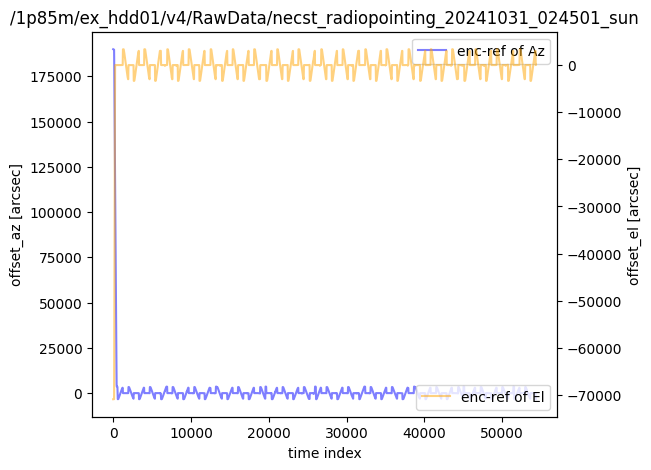

In [15]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(offset_az * 3600, color="blue", alpha=0.5, label="enc-ref of Az")
ax2.plot(offset_el * 3600, color="orange", alpha=0.5, label="enc-ref of El")
ax1.title.set_text(RAWDATA_PATH)
ax1.set_xlabel("time index")
ax1.set_ylabel("offset_az [arcsec]")
ax2.set_ylabel("offset_el [arcsec]")
ax1.legend()
ax2.legend()

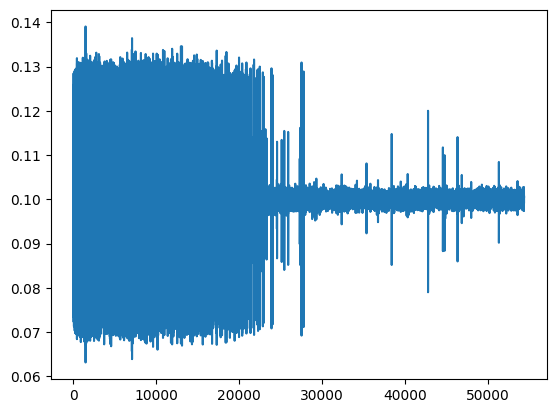

In [16]:
plt.plot(df.time.diff())

653          NaN
654     0.098860
655     0.101017
656     0.101431
657     0.127050
          ...   
1149    0.099959
1150    0.100144
1151    0.100009
1152    0.100627
1153    0.098755
Name: time, Length: 501, dtype: float64
653            NaN
654      61.541855
655      64.040556
656      64.134156
657     104.614191
           ...    
1149    121.298147
1150    103.494814
1151    231.350157
1152    114.053220
1153    113.116432
Length: 501, dtype: float64


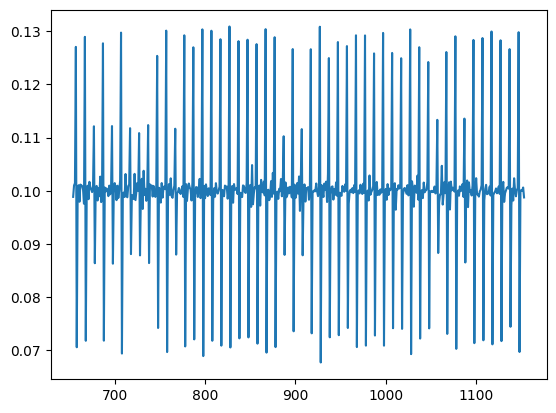

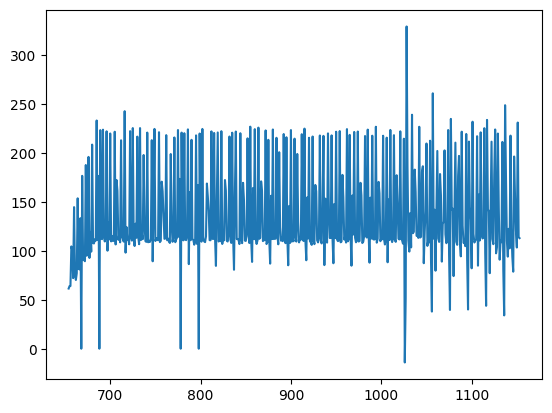

In [17]:
start, _, end = get_scan_range(0, 0)
l = df.lon[start:end+1]
t = df.time[start:end+1]
l_diff = l.diff() * 3600
t_diff = t.diff()
print(t_diff)
plt.plot(t_diff)
print(l_diff / t_diff)
plt.figure()
plt.plot(l_diff / t_diff)
# plt.ylim(0, 250)

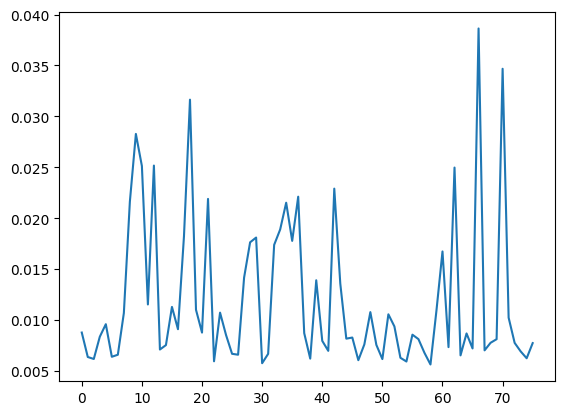

In [18]:
ldm = []
for i in range(scan_num):
    start, _, end = get_scan_range(i // 2, i % 2)
    if i % 2 == 0:
        l = df.lon[start:end+1]
    else:
        l = df.lat[start:end+1]
    l_diff = l.diff()
    ldm.append(abs(l_diff).max())
plt.plot(ldm)

# 解析に必要な関数の定義

In [19]:
class planetAnalysis():
    def __init__(self, cross_id: int, axis: Literal[0, 1]) -> None:
        # self.data_num = data_num
        self.scan_id = cross_id * 2 + axis
        self.cross_id = cross_id
        self.axis = axis
        self.idx_scan_start, self.idx_scan_center, self.idx_scan_end = get_scan_range(cross_id, axis)
        self.df_scan = df[self.idx_scan_start:self.idx_scan_end + 1]
        # if self.axis == 0:
        #     self.fig, self = plt.subplots(1, 2)
        #     self.fig.suptitle(str(rawdata_path))

    # def plot(self):
    #     plt.title(f"{RAWDATA_PATH}\ncross_id: {self.cross_id} - {self.axis} (scan_id: {self.scan_id})")
    #     plt.plot(self.df_scan.integrated)

    def gauss(self, start, end):
        # print(f"tp: {self.df_scan.integrated}")
        # plt.plot(self.df_scan.integrated)
        scan_data = self.df_scan.integrated.loc[start:end].values
        # print(self.df_scan.keys())
        self.scan_offset_x = self.df_scan.offset_x.loc[start:end].values[5:-5]
        self.scan_offset_el = self.df_scan.offset_el.loc[start:end].values[5:-5]
        self.scan_offset_x_interp = (self.scan_offset_x[1:] + self.scan_offset_x[:-1]) / 2
        self.scan_offset_el_interp = (self.scan_offset_el[1:] + self.scan_offset_el[:-1]) / 2

        kernel = Box1DKernel(10)
        self.scan_data_convolve = convolve(scan_data, kernel)[5:-5]  # 畳み込み結果、データの左右端が低い値になっているためそこを切る
        self.scan_data_convolve_diff = np.diff(self.scan_data_convolve)

        # f = plt.figure()
        # ax = f.add_subplot(111)
        # ax2 = ax.twinx()

        # if self.axis == "az":
        #     ax.plot(self.scan_offset_x, self.scan_data_convolve, c="red", label="frequency-integrated scan")
        #     ax.set_ylim(2.5e15,4.0e15)

        #     ax2.plot(self.scan_offset_x[1:], np.diff(self.scan_data_convolve), c="blue", label="differential")
        #     ax2.set_ylim(-3e13,5e13)
            
        # else:
        #     ax.plot(self.scan_offset_el, self.scan_data_convolve, c="red", label="frequency-integrated scan")
        #     ax.set_ylim(2.5e15,4.0e15)

        #     ax2.plot(self.scan_offset_el[1:], np.diff(self.scan_data_convolve), c="blue", label="differential")
        #     ax2.set_ylim(-3e13,5e13)

    def last(self, fig, left_param, right_param, left_range, right_range):
        last_axis = self.axis
        l_a = left_param[0]
        l_mu = left_param[1]
        l_sigma = left_param[2]
        r_a = right_param[0]
        r_mu = right_param[1]
        r_sigma = right_param[2]
        l_start = left_range[0]
        l_end = left_range[1]
        r_start = right_range[0]
        r_end = right_range[1]

        ax = fig.add_subplot((scan_num + 1) // 2, 2, self.scan_id + 1)
        ax2 = ax.twinx()

        if last_axis == 0:
            ax.plot(self.scan_offset_x, self.scan_data_convolve, c="red", label="frequency-integrated scan")

            #initial guess of the fit
            p0_left = [l_a, l_mu, l_sigma]
            p0_right = [r_a, r_mu, r_sigma]
            
            popt_left, _ = curve_fit(
                gaussian_func, 
                xdata=self.scan_offset_x_interp[l_start:l_end],
                ydata=self.scan_data_convolve_diff[l_start:l_end],
                p0=p0_left,
                maxfev=20000
            )
            popt_right, _ = curve_fit(
                gaussian_func, 
                xdata=self.scan_offset_x_interp[r_start:r_end],
                ydata=self.scan_data_convolve_diff[r_start:r_end],
                p0=p0_right,
                maxfev=20000
            )

            ax2.plot(self.scan_offset_x_interp, self.scan_data_convolve_diff, c="orange", label="differential")
            ax2.plot(self.scan_offset_x_interp[l_start:l_end], 
                     gaussian_func(
                         self.scan_offset_x_interp[l_start:l_end], 
                         popt_left[0], 
                         popt_left[1], 
                         popt_left[2]),
                    c="blue")
            ax2.plot(
                self.scan_offset_x_interp[r_start:r_end], 
                gaussian_func(self.scan_offset_x_interp[r_start:r_end], 
                              popt_right[0], 
                              popt_right[1], 
                              popt_right[2]),c="blue")
            ax.set_xlabel("offset x")
            max_range = abs(obs_radius_az.to("deg").value * 1.2)
            
        elif last_axis == 1:
            ax.plot(self.scan_offset_el, self.scan_data_convolve, c="red", label="frequency-integrated scan")

            #initial guess of the fit
            p0_left = [l_a, l_mu, l_sigma]
            p0_right = [r_a, r_mu, r_sigma]
            
            popt_left, _ = curve_fit(
                f=gaussian_func, 
                xdata=self.scan_offset_el_interp[l_start:l_end], 
                ydata=self.scan_data_convolve_diff[l_start:l_end],
                p0=p0_left,
                maxfev=20000
            )
            popt_right, _ = curve_fit(
                f=gaussian_func, 
                xdata=self.scan_offset_el_interp[r_start:r_end], 
                ydata=self.scan_data_convolve_diff[r_start:r_end],
                p0=p0_right,
                maxfev=20000
            )

            ax2.plot(self.scan_offset_el_interp, self.scan_data_convolve_diff, c="orange", label="differential")
            ax2.plot(self.scan_offset_el_interp[l_start:l_end],
                     gaussian_func(
                         self.scan_offset_el_interp[l_start:l_end], 
                         popt_left[0], 
                         popt_left[1], 
                         popt_left[2]),
                    c="blue")
            ax2.plot(
                self.scan_offset_el_interp[r_start:r_end], 
                gaussian_func(self.scan_offset_el_interp[r_start:r_end], 
                              popt_right[0], 
                              popt_right[1], 
                              popt_right[2]),c="blue")
            ax.set_xlabel("offset y")
            max_range = abs(obs_radius_el.to("deg").value * 1.2)
        
        ax.grid(which='major', linewidth=1)
        #ax.set_xlim(-0.60, 0.4)
        #ax.set_ylim(4.2e15,4.6e15)
        # ax2.set_ylim(-8e13,8e13)
        # max_range = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]))
        ax.set_xlim(-max_range, max_range)
        ax.set_ylabel("total power")
        ax.set_title(f"{DATETIME}_{PLANET}\ncross_id: {self.cross_id} - {self.axis} (scan_id: {self.scan_id})")

        # print(self.scan_data_convolve)
        print(f"fitted_upper = {popt_left}")
        print(f"fitted_lower = {popt_right}")
        self.d = (popt_left[1] + popt_right[1]) / 2 * u.deg
        self.d = self.d.to(u.arcsec)
        # print(f"d = {self.d}")
        self.center_az = reference_enc[0][self.idx_scan_center]
        self.center_el = reference_enc[1][self.idx_scan_center]
        # self.centre_az = np.mean(reference_altaz.az[r_start:r_end])
        # self.centre_el = np.mean(reference_altaz.alt[r_start:r_end])
        # print(f"az = {self.center_az}")
        # print(f"el = {self.center_el}")
        ax.text(0.05, 0.05, f"d: {self.d:.2f}\nAz: {self.center_az:.2f}\nEl: {self.center_el:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment="bottom")

In [20]:
class CalcD():
    def fit(fig, cross_id: int, axis: Literal[0, 1], data_range: float = 3.6e15, gauss_sigma: float = 20.0) -> None:
        print(f"==================== cross {cross_id} - {axis} (scan {cross_id * 2 + axis}) ====================")
        planet = planetAnalysis(cross_id=cross_id, axis=axis)
        # planet.plot()
        df_scan_copy = planet.df_scan.copy()
        # if df_scan_copy['integrated'].iloc[:400].max() > 0:
        #     df_scan_copy.iloc[:400, df_scan_copy.columns.get_loc('integrated')] = 0
        # elif df_scan_copy['integrated'].iloc[-300:].max() > 0:
        #     df_scan_copy.iloc[-300:, df_scan_copy.columns.get_loc('integrated')] = 0
        # else:
        #     pass
        # print(f"max_tp_idx: {((df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e4)}")
        # print(max(df_scan_copy.integrated) - 1e13)
        # plot_left = np.array(planet.df_scan.integrated[(df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14].index).min() - 400
        # plot_right = np.array(planet.df_scan.integrated[(df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14].index).max() + 300
        plot_left = planet.df_scan.integrated[((df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14)].index[0] - 400/1
        plot_right = planet.df_scan.integrated[((df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14)].index[-1] + 300/1
        planet.gauss(plot_left, plot_right)
        diff = np.diff(planet.scan_data_convolve)[10:-10]
        # print(planet.scan_data_convolve)
        left_min = np.array(np.where(diff > max(diff) - 1.0e12)).min() - 10
        left_min = max(left_min, 0)
        left_max = np.array(np.where(diff > max(diff) - 1.0e12)).max() + 30
        right_min = np.array(np.where(diff < min(diff) + 1.0e12)).min() - 10
        right_min = max(right_min, 0)
        right_max = np.array(np.where(diff < min(diff) + 1.0e12)).max() + 30
        # print(f"planet.scan_data_convolve: {planet.scan_data_convolve}")  ##########
        # print(f"plot_left: {plot_left}")  ##########
        # print(f"plot_right: {plot_right}")  ##########
        # print(f"left_min: {left_min}")  ##########
        # print(f"left_max: {left_max}")  ##########
        # print(f"right_min: {right_min}")  ##########
        # print(f"right_max: {right_max}")  ##########
        plot_blue=np.diff(planet.scan_data_convolve)[left_min:left_max]
        plot_orange=np.diff(planet.scan_data_convolve)[right_min:right_max]
        # print(f"diff_left: {plot_blue}")
        # direction: 増加方向なら1、減少方向なら-1
        if axis == 0:
            direction = 1 if np.median(planet.scan_offset_x[1:] - planet.scan_offset_x[:-1]) > 0 else -1
        elif axis == 1:
            direction = 1 if np.median(planet.scan_offset_el[1:] - planet.scan_offset_el[:-1]) > 0 else -1
        # left_param = [max(plot_blue), np.argmax(plot_blue), 20]  # initial a, mu=視直径/2, sigma=0.025deg(90arcsec)
        # right_param = [min(plot_orange), np.argmin(plot_orange), 20]
        left_param = [max(plot_blue), -0.25 * direction, 0.025]
        right_param = [min(plot_orange), 0.25 * direction, 0.025]
        print(f"init_upper: {left_param}")
        print(f"init_lower: {right_param}")
        left_range = [left_min, left_max]  # fitting target range
        right_range = [right_min, right_max]

        planet.last(fig, left_param, right_param, left_range, right_range)
    
        # plt.savefig(save_path / f"tp/cross{cross_id}-{axis}.png")

        df_before = pd.read_csv(save_path / "d_param_before_reduce.csv")
        df_before.at[planet.scan_id, "dt_cross_id"] = f"{DATETIME}_{planet.cross_id}"
        df_before.at[planet.scan_id, "scan_id"] = planet.scan_id
        df_before.at[planet.scan_id, "cross_id"] = planet.cross_id
        df_before.at[planet.scan_id, "axis"] = planet.axis
        df_before.at[planet.scan_id, "Az"] = planet.center_az.value  # deg
        df_before.at[planet.scan_id, "El"] = planet.center_el.value  # deg
        df_before.at[planet.scan_id, "dx"] = planet.d.value if axis == 0 else np.nan  # arcsec
        df_before.at[planet.scan_id, "dEl"] = planet.d.value if axis == 1 else np.nan  # arcsec
        # 変更をCSVファイルに書き込む
        df_before.to_csv(save_path / "d_param_before_reduce.csv", index=False)

    def reduce(good_scan_id: List[int]):
        df_before = pd.read_csv(save_path / "d_param_before_reduce.csv")
        df_after = df_before.iloc[good_scan_id]
        # 変更をCSVファイルに書き込む
        df_after.to_csv(save_path / "d_param.csv", index=False)

In [21]:
# !pip install joblib
# from joblib import Parallel, delayed
# from IPython.display import display

# def process_planet(i):
#     plt.figure()
#     planet = planetAnalysis(cross_id=i // 2, axis=i % 2)
#     planet.plot()
#     return plt.gcf()


# figures = Parallel(n_jobs=-1)(delayed(process_planet)(i) for i in range(scan_num))


# for fig in figures:
#     display(fig)
#     plt.close(fig)

# スキャン解析実行 (TP・fitting 確認)【重要：要目視判断】
事前に各 `scan_id` の TP や fitting 結果を確認し、<br>
天体が受かっていないものや正常に fitting できていないものは `BAD_SCAN_ID` として以下の「データ抽出・保存」で除外すること<br>
- `cross_id`：何回目のクロススキャンか
- `scan_id`：何回目のスキャンか

|cross_id|scan_id (Az 方向)|scan_id (El 方向)|
|:-:|:-:|:-:|
|0|0|1|
|1|2|3|
|2|4|5|
|...|...|...|
|n|2n|2n+1|

Fitting 76 scan(s)...
==================== cross 0 - 0 (scan 0) ====================
init_upper: [266644450000000.0, -0.25, 0.025]
init_lower: [-282154660000000.0, 0.25, 0.025]
fitted_upper = [ 2.61535403e+14 -2.72101378e-01  2.53572820e-02]
fitted_lower = [-2.78454738e+14  2.73399174e-01  2.44209068e-02]
==================== cross 0 - 1 (scan 1) ====================
init_upper: [352936250000000.0, 0.25, 0.025]
init_lower: [-325897300000000.0, -0.25, 0.025]
fitted_upper = [3.56070495e+14 2.55612802e-01 2.55658217e-02]
fitted_lower = [-3.29415522e+14 -2.84341430e-01  2.70734505e-02]
==================== cross 1 - 0 (scan 2) ====================
init_upper: [281142650000000.0, 0.25, 0.025]
init_lower: [-253462130000000.0, -0.25, 0.025]
fitted_upper = [2.72020879e+14 2.68017102e-01 2.49532909e-02]
fitted_lower = [-2.49495613e+14 -2.76673622e-01  2.86298825e-02]
==================== cross 1 - 1 (scan 3) ====================
init_upper: [344645900000000.0, -0.25, 0.025]
init_lower: [-346678

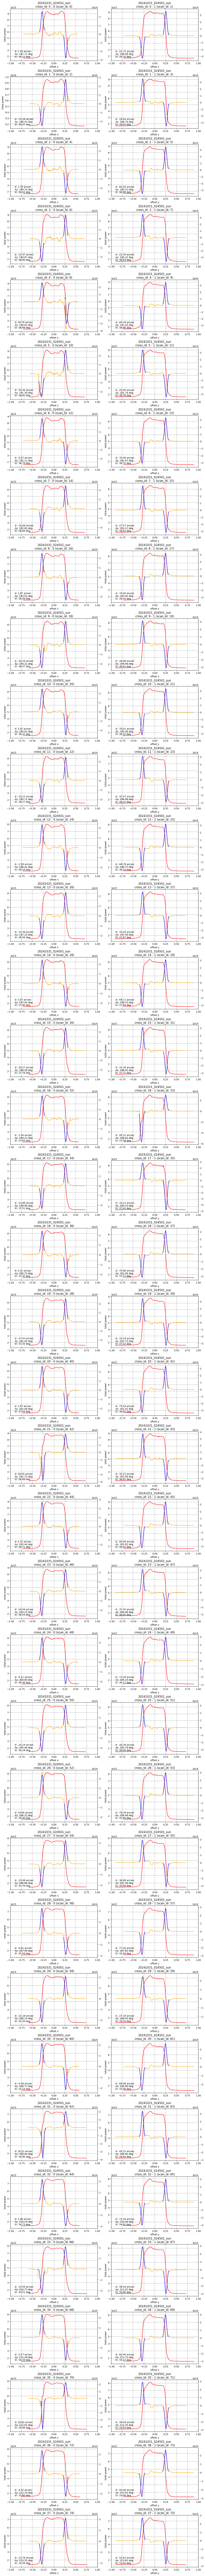

In [22]:
BAD_SCAN_ID = []  # ここは変更不要
good_scan_id = [_scan_id for _scan_id in range(scan_num) if _scan_id not in BAD_SCAN_ID]
df_save = pd.DataFrame(columns=["dt_cross_id", "scan_id", "cross_id", "axis", "dx", "dEl", "Az", "El"])
df_save.to_csv(save_path / "d_param_before_reduce.csv", index=False)
print(f"Fitting {scan_num} scan(s)...")
fig = plt.figure(figsize=(12, min((scan_num + 1) // 2 * 4, 327)), constrained_layout=True)
# fig.suptitle(str(rawdata_path))
for _scan_id in good_scan_id:
    CalcD.fit(fig=fig, cross_id=_scan_id // 2, axis=_scan_id % 2)
plt.savefig(save_path / "scans.png")

# === STOP ============================================

# データ抽出・保存【重要・要入力】
上の出力結果を見て選んだ `BAD_SCAN_ID` を以下に入力して実行するとそれを除いたデータが保存される

In [22]:
np.arange(1, 76, 4)

array([ 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73])

In [23]:
# ======================================================================
BAD_SCAN_ID = [8, 10, 33, 42, 62, 70,
               0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64,
       68, 72, 1,  5,  9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65,
       69, 73]  # 保存時に除外する scan_id (0, 1, 2, ...) リスト  e.g. [4, 5, 7]
# ======================================================================
good_scan_id = [_scan_id for _scan_id in range(scan_num) if _scan_id not in BAD_SCAN_ID]
print(f"GOOD_SCAN_ID = {good_scan_id}")
CalcD.reduce(good_scan_id=good_scan_id)

GOOD_SCAN_ID = [2, 3, 6, 7, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 43, 46, 47, 50, 51, 54, 55, 58, 59, 63, 66, 67, 71, 74, 75]


# === エッジ検出ここまで ===============

# スプリアス確認
岡本くんに渡した (10/23)

In [23]:
freqs = [freq * (2500 / 32767) for freq in range(32768)]
print(freqs[0])
print(freqs[32767])
print(freqs[16384])

0.0
2500.0
1250.038148136845


1626.1024811548202
1250.038148136845
1626.1024811548202


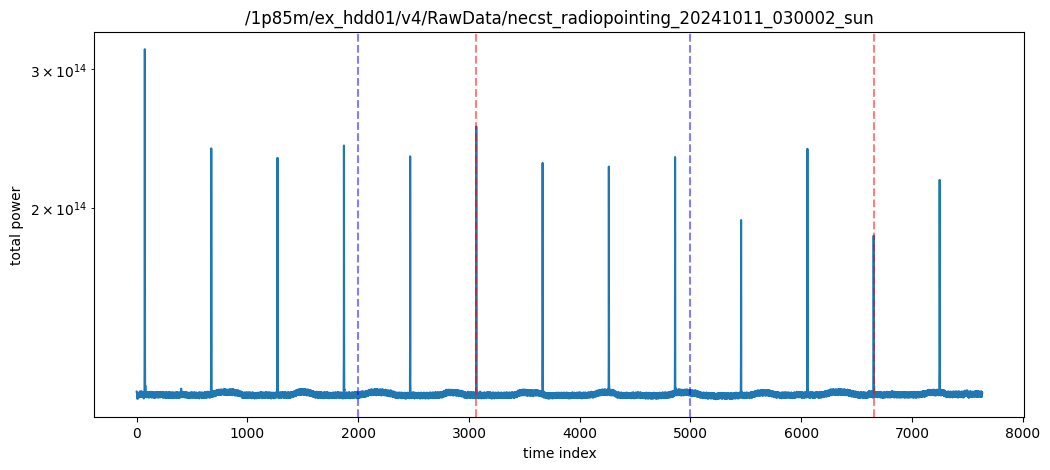

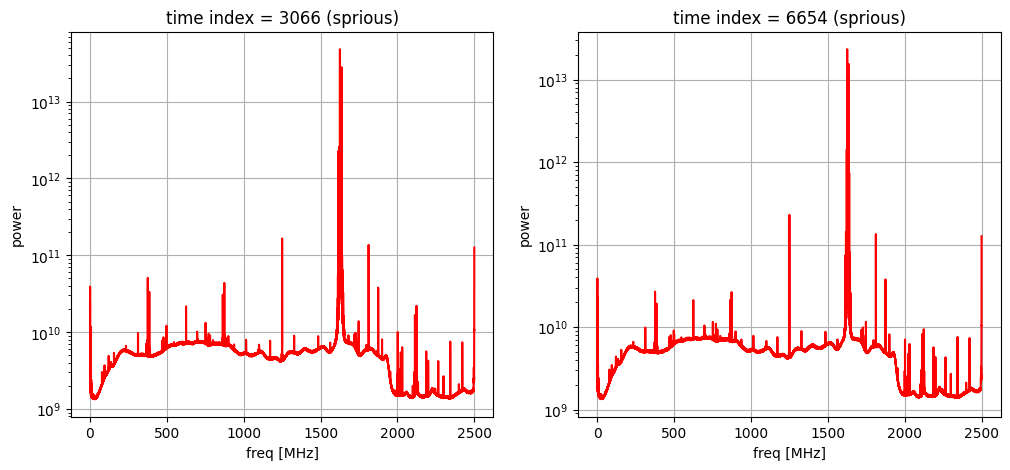

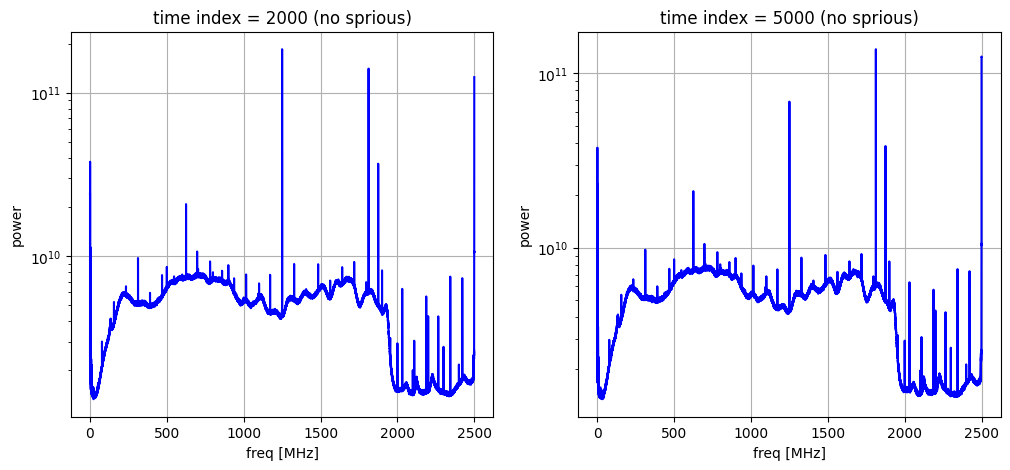

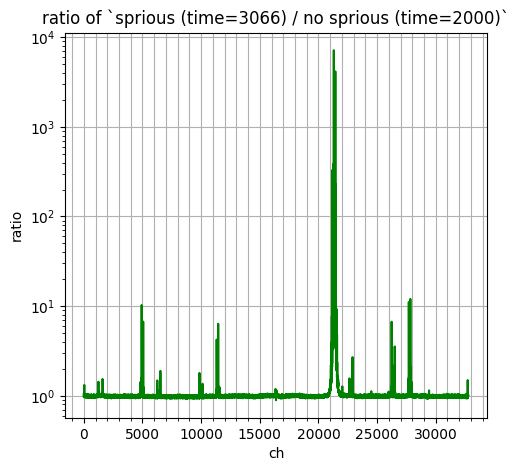

In [40]:
idx_spr = [3066, 6654]
# idx_spr = [5970, 5971, 5972]
# idx_spr = [320, 321, 322, 323, 324, 325]
idx_nospr = [2000, 5000]

print(np.argmax(data.data[idx_spr[0]]) * (2500 / 32767))
print(np.argmax(data.data[idx_nospr[0]]) * (2500 / 32767))
print(np.argmax(data.data[idx_spr[0]] / data.data[idx_nospr[1]]) * (2500 / 32767))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(integrated)
ax.set_yscale("log")
ax.title.set_text(RAWDATA_PATH)
ax.set_xlabel("time index")
ax.set_ylabel("total power")
for t_idx in idx_spr:
    ax.axvline(x=t_idx, color="red", linestyle="--", alpha=0.5)
for t_idx in idx_nospr:
    ax.axvline(x=t_idx, color="blue", linestyle="--", alpha=0.5)
# ax.set_xlim(6650, 6660)

# fig = plt.figure(figsize=(12, 5))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(integrated)
# ax.set_yscale("log")
# ax.title.set_text(RAWDATA_PATH)
# ax.set_xlabel("time index")
# ax.set_ylabel("total power")
# ax.set_xlim(6600, 6610)

fig = plt.figure(figsize=(12, 5))
for i, t_idx in enumerate(idx_spr):
    ax = fig.add_subplot(1, len(idx_spr), i + 1)
    ax.plot(freqs, data.data[t_idx], color="red")
    ax.title.set_text(f"time index = {t_idx} (sprious)")
    ax.set_yscale("log")
    ax.set_xlabel("freq [MHz]")
    ax.set_ylabel("power")
    ax.grid()

fig = plt.figure(figsize=(12, 5))
for i, t_idx in enumerate(idx_nospr):
    ax = fig.add_subplot(1, len(idx_nospr), i + 1)
    ax.plot(freqs, data.data[t_idx], color="blue")
    ax.title.set_text(f"time index = {t_idx} (no sprious)")
    ax.set_yscale("log")
    ax.set_xlabel("freq [MHz]")
    ax.set_ylabel("power")
    ax.grid()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(data.data[idx_spr[0]] / data.data[idx_nospr[0]], color="green")
ax.title.set_text(f"ratio of `sprious (time={idx_spr[0]}) / no sprious (time={idx_nospr[0]})`")
ax.set_yscale("log")
ax.set_xlabel("ch")
ax.set_ylabel("ratio")
ax.grid()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
ax.grid(which="minor", axis="x")

# ax = fig.add_subplot(1, 2, 2)
# ax.plot(freqs, data.data[10000] / data.data[8000], color="green")
# ax.title.set_text("ratio of `no sprious (time=10000) / no sprious (time=8000)`")
# ax.set_yscale("log")
# ax.set_xlabel("freq [MHz]")
# ax.set_ylabel("ratio")

# === パラメータ計算・プロットここから (以下は古いもの、要更新) ===

# a1, a2, a3, b1, b2, b3, g1 の計算

本来光学ポインティングで行うフィッティング<br>
後の d1, d2 の計算とは必ずどちらかのみを行い、両方同時に行わないこと
- a1：Az-El の非直交性
- a2：光学軸と El 軸の非直交性
- a3：Az エンコーダのオフセット
- b1：天頂からの Az 軸の傾き (南北方向)
- b2：天頂からの El 軸の傾き (東西方向)
- b3：El エンコーダのオフセット
- g1：重力の影響によるオフセット

## 定数や関数の定義
- 以下の定数は再設定したい場合のみ指定すること

In [17]:
# ======================================================================
# DATETIME = "20240905"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
SAVE_PATH = f"./{DATETIME}_sun"  # 解析結果の保存先
# ======================================================================
print(f"Analysis target data is {SAVE_PATH!r}.")
save_path = Path(SAVE_PATH)
# ======================================================================

Analysis target data is './20241002_233609_sun'.


- 以降は設定不要

In [18]:
# RAWDATA_PATH = "./necst_radiopointing_20230330_121827_moon"
# dir_save = f"./1p85m_analy/20230330_csv/{PLANET}_{data_num}"

# date = "20240525_1"
# dbname = "necst_opticalpointing_20240525_113626"

data_dir = save_path
# pic_dir = "pics" + "/" + date +"/"
kisa_file = rawdata_path / "pointing_param.toml"
figs = save_path

In [19]:
def write_param(filepath, model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="deg"):
    with open(filepath, mode="w") as file:
        param = (
            f'[metadata]\n'
            f'model = "{model}"\n'
            f'\n'
            f'[pointing_params]\n'
            f'"a1[{unit}]" = {a1.to(unit).value}\n'
            f'"a2[{unit}]" = {a2.to(unit).value}\n'
            f'"a3[{unit}]" = {a3.to(unit).value}\n'
            f'"b1[{unit}]" = {b1.to(unit).value}\n'
            f'"b2[{unit}]" = {b2.to(unit).value}\n'
            f'"b3[{unit}]" = {b3.to(unit).value}\n'
            f'g1 = {g1}\n'
            f'"c1[{unit}]" = {c1.to(unit).value}\n'
            f'"c2[{unit}]" = {c2.to(unit).value}\n'
            f'"d1[{unit}]" = {d1.to(unit).value}\n'
            f'"d2[{unit}]" = {d2.to(unit).value}\n'
            f'"e1[{unit}]" = {e1.to(unit).value}\n'
            f'"e2[{unit}]" = {e2.to(unit).value}\n'
        )
        file.write(param)
    print(f"======= {filepath!r} =======")
    print(param)

In [20]:
param_before = Parameters.from_file(kisa_file)
def apply_kisa():
        if param_before.model != "omu1p85m":
                raise NotImplementedError(f"This analysis is only for model omu1p85m, not {param_before.model}.")
        # fkisa = open(kisa_file,"r")
        # kisa = fkisa.readlines()
        param_delta = Parameters.from_file(data_dir / "pointing_param_delta.toml")
        # fdkisa = open(f"{data_dir}/pointing_param_delta", "r")
        # dkisa = fdkisa.readlines()
        a1 = param_before.a1 + param_delta.a1
        a2 = param_before.a2 + param_delta.a2
        a3 = param_before.a3 + param_delta.a3
        b1 = param_before.b1 + param_delta.b1
        b2 = param_before.b2 + param_delta.b2
        b3 = param_before.b3 + param_delta.b3
        g1 = param_before.g1 + param_delta.g1
        c1 = param_before.c1 + param_delta.c1
        c2 = param_before.c2 + param_delta.c2
        d1 = param_before.d1 + param_delta.d1
        d2 = param_before.d2 + param_delta.d2
        e1 = param_before.e1 + param_delta.e1
        e2 = param_before.e2 + param_delta.e2
        # fkisa.close()

        # old_kisa_file = f"{data_dir}/pointing_param_before.toml"
        # shutil.copy(kisa_file, old_kisa_file)
        # print("``pointing_param_before.toml`` was created.")

        write_param(data_dir / "pointing_param_after.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
        # nkisa = open(kisa_file,"w")
        # param_new = (f'[metadata]\n'
        #              f'model = "{param.model}"\n'
        #              f'\n'
        #              f'[pointing_params]\n'
        #              f'"a1[deg]" = {a1.to("deg").value}\n'
        #              f'"a2[deg]" = {a2.to("deg").value}\n'
        #              f'"a3[deg]" = {a3.to("deg").value}\n'
        #              f'"b1[deg]" = {b1.to("deg").value}\n'
        #              f'"b2[deg]" = {b2.to("deg").value}\n'
        #              f'"b3[deg]" = {b3.to("deg").value}\n'
        #              f'g1 = {g1}\n'
        #              f'"c1[deg]" = {c1.to("deg").value}\n'
        #              f'"c2[deg]" = {c2.to("deg").value}\n'
        #              f'"d1[deg]" = {d1.to("deg").value}\n'
        #              f'"d2[deg]" = {d2.to("deg").value}\n'
        #              f'"e1[deg]" = {e1.to("deg").value}\n'
        #              f'"e2[deg]" = {e2.to("deg").value}\n')
        # nkisa.write(param_new)
        # nkisa.write(str(a1)+"\n")
        # nkisa.write(str(a2)+"\n")
        # nkisa.write(str(a3)+"\n")
        # nkisa.write(str(b1)+"\n")
        # nkisa.write(str(b2)+"\n")
        # nkisa.write(str(b3)+"\n")
        # nkisa.write(str(g1)+"\n")
        # nkisa.write(str(c1)+"\n")
        # nkisa.write(str(c2)+"\n")
        # nkisa.write(str(d1)+"\n")
        # nkisa.write(str(d2)+"\n")    
        # nkisa.write(str(e1)+"\n")
        # nkisa.write(str(e2)+"\n")
        # nkisa.close()

        # new_kisa_file = data_dir + "pointing_param_after.toml"
      #  shutil.copy(f"{data_dir}/pointing_param_after.toml", kisa_file)
       # print("``pointing_param_after.toml`` was created and pointing_param was updated.")
       # print("Data location : " + data_dir)
       # print("======= ``pointing_param_delta.toml`` =======")
       # print(param_delta)
        # print(a1)
        # print(a2)
        # print(a3)
        # print(b1)
        # print(b2)
        # print(b3)
        # print(g1)
        # print(c1)
        # print(c2)
        # print(d1)
        # print(d2)
        # print(e1)
        # print(e2)

## ここから実処理

In [21]:
csv = pd.read_csv(save_path / "d_param.csv")
csv

dt_cross_id  scan_id  cross_id  axis         dx        dEl  \
0  20241002_233609_0      0.0       0.0   0.0   0.670682        NaN   
1  20241002_233609_0      1.0       0.0   1.0        NaN -51.077997   
2  20241002_233609_1      2.0       1.0   0.0  10.411486        NaN   
3  20241002_233609_1      3.0       1.0   1.0        NaN -41.043839   
4  20241002_233609_2      4.0       2.0   0.0 -12.483979        NaN   
5  20241002_233609_2      5.0       2.0   1.0        NaN -47.306924   
6  20241002_233609_3      6.0       3.0   0.0  -8.317709        NaN   
7  20241002_233609_3      7.0       3.0   1.0        NaN -25.817038   
8  20241002_233609_4      8.0       4.0   0.0 -23.897150        NaN   
9  20241002_233609_4      9.0       4.0   1.0        NaN -16.028270   

           Az         El  
0  126.921122  31.988104  
1  127.178597  32.182073  
2  127.437280  32.375437  
3  127.697175  32.568184  
4  127.958296  32.760312  
5  128.216897  32.949081  
6  128.480482  33.139955  
7  128.747223  33.331546  
8  129.087693  33.573817  
9  129.357359  33.763903

In [22]:
csv_az = csv.dropna(subset=["dx"])
csv_el = csv.dropna(subset=["dEl"])
csv_union = pd.DataFrame(columns=["cross_id", "dx", "dEl", "Az", "El"])
for _cross_id in np.unique(csv.cross_id):
    if _cross_id not in csv_az.cross_id.values or _cross_id not in csv_el.cross_id.values:
        continue
    dx = csv_az[csv_az.cross_id == _cross_id].dx.values[0]
    dEl = csv_el[csv_el.cross_id == _cross_id].dEl.values[0]
    Az = (csv_az[csv_az.cross_id == _cross_id].Az.values[0] + csv_el[csv_el.cross_id == _cross_id].Az.values[0]) / 2
    El = (csv_az[csv_az.cross_id == _cross_id].El.values[0] + csv_el[csv_el.cross_id == _cross_id].El.values[0]) / 2
    csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
csv_union

/tmp/ipykernel_14757/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/tmp/ipykernel_14757/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/tmp/ipykernel_14757/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/tmp/ipykernel_14757/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

cross_id         dx        dEl          Az         El
0       0.0   0.670682 -51.077997  127.049860  32.085088
1       1.0  10.411486 -41.043839  127.567227  32.471811
2       2.0 -12.483979 -47.306924  128.087597  32.854696
3       3.0  -8.317709 -25.817038  128.613852  33.235750
4       4.0 -23.897150 -16.028270  129.222526  33.668860

In [23]:
# rms の計算
dx_sigma = np.nanstd(csv["dx"])
dy_sigma = np.nanstd(csv["dEl"])
d_sigma = np.sqrt(dx_sigma**2 + dy_sigma**2)

print(f"sigma = {d_sigma:.2f} arcsec")

sigma = 17.67 arcsec


In [24]:
def f_az2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180
    el = _el * np.pi / 180
    # return np.cos(el) * ((a1 * np.tan(el)) + (a2 / np.cos(el)) + a3 + (b1 * np.sin(az) * np.sin(el) - b2 * np.cos(az) * np.sin(el)) / np.cos(el))
    return a1 * np.sin(el) + a2 + a3 * np.cos(el) + b1 * np.sin(az) * np.sin(el) + b2 * np.cos(az) * np.sin(el) 

def f_el2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180
    return b1 * np.cos(az) + b2 * np.sin(az) + b3 + g1 * _el

def eval_func(p, az, el, dx):
    results_dx = f_az2([az, el], *p)
    return (dx - results_dx) ** 2

def eval_func2(p, az, el, dy):
    results_dy = f_el2([az, el],*p)
    return (dy - results_dy) ** 2

def eval_func3(p, az, el, dx, dy):
    results_dx = f_az2([az, el], *p)
    results_dy = f_el2([az, el], *p)
    return (dx - results_dx) ** 2 + (dy - results_dy) ** 2

In [25]:
pp1 = optimize.least_squares(eval_func, x0=[0,0,0,0,0,0,0], args=(csv_az["Az"], csv_az["El"], csv_az["dx"]))
pp2 = optimize.least_squares(eval_func2, x0=[0,0,0,0,0,0,0], args=(csv_el["Az"], csv_el["El"], csv_el["dEl"]))
print(pp1.x)
print(pp2.x)

[ 2262.64617517  -975.77945218 -3279.75356836 10928.11864508
  6482.17706283     0.             0.        ]
[-6.86038136e-07 -7.80203712e-10  4.39376265e-12 -1.83585648e+04
 -1.67681869e+04  2.07210206e+04 -5.74969362e+02]


In [26]:
pp = list(pp1.x[0:3])+list(pp2.x[3:7])
print(pp)

[2262.646175168405, -975.779452182502, -3279.7535683620436, -18358.56483303878, -16768.186897258718, 20721.02061577343, -574.9693622664756]


In [27]:
pp3 = optimize.least_squares(eval_func3, x0=pp, args=(csv_union["Az"], csv_union["El"], csv_union["dx"], csv_union["dEl"]))
print(pp3.x)
print(pp3.x / 3600)

[-65293.70655691 -80239.55016704  64439.54017159  94587.54368062
 -63177.59574792  79638.89232191    864.17666247]
[-18.13714071 -22.28876394  17.89987227  26.27431769 -17.54933215
  22.12191453   0.24004907]


In [28]:
# bestfit_dx = f_az2([csv["Az"],csv["El"]], *pp3.x)
# bestfit_dy = f_el2([csv["Az"],csv["El"]], *pp3.x)

# debug
bestfit_dx = f_az2([csv["Az"],csv["El"]], *pp1.x)
bestfit_dy = f_el2([csv["Az"],csv["El"]], *pp2.x)

In [29]:
error_dx = csv["dx"] - bestfit_dx
error_dy = csv["dEl"] - bestfit_dy

bestfit_dx_sigma = np.nanstd(error_dx)
bestfit_dy_sigma = np.nanstd(error_dy)
bestfit_d_sigma = np.sqrt(bestfit_dx_sigma**2 + bestfit_dy_sigma**2)

print(f"bestfit_sigma = {bestfit_d_sigma:.2f} arcsec")

bestfit_sigma = 7.80 arcsec


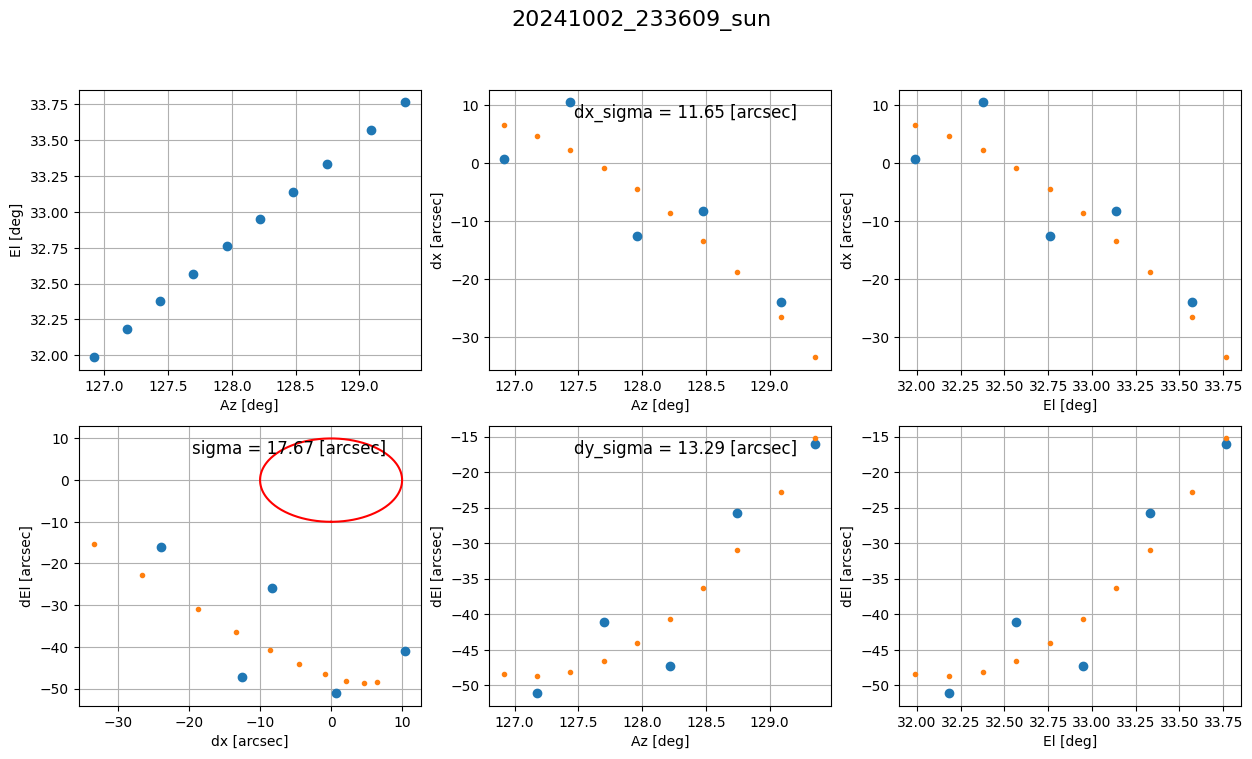

In [30]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]
[_ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False)) for _ax in ax]
[_ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False)) for _ax in ax]

ax[0].plot(csv['Az'], csv['El'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(csv['Az'], csv['dx'], 'o')
ind1=np.argsort(csv['Az'])
ax[1].plot(csv['Az'][ind1], bestfit_dx[ind1], '.')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'dx_sigma = %0.2f [arcsec]'%dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(csv['El'], csv['dx'], 'o')
ind2=np.argsort(csv['El'])
ax[2].plot(csv['El'][ind2], bestfit_dx[ind2], '.')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(csv_union['dx'], csv_union['dEl'], 'o')
ax[3].plot(bestfit_dx, bestfit_dy, '.')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dEl [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(csv['Az'], csv['dEl'], 'o')
ax[4].plot(csv['Az'][ind1], bestfit_dy[ind1], '.')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dEl [arcsec]')
ax[4].text(0.9, 0.95, 'dy_sigma = %0.2f [arcsec]'%dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(csv['El'], csv['dEl'], 'o')
ax[5].plot(csv['El'][ind2], bestfit_dy[ind2], '.')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dEl [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle(str(save_path.name), fontsize=16)
fig.savefig(figs / "pointing_results.png")

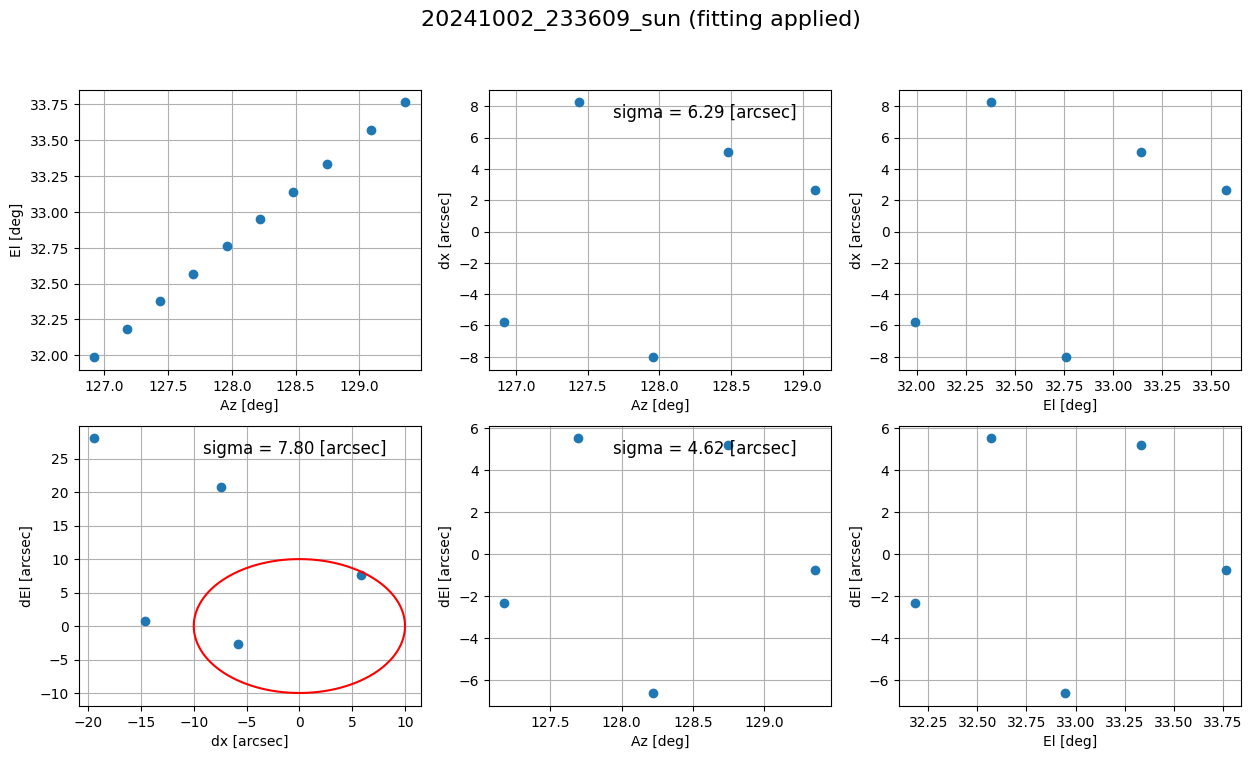

In [31]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]

ax[0].plot(csv['Az'], csv['El'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(csv['Az'], csv['dx']-bestfit_dx, 'o')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(csv['El'], csv['dx']-bestfit_dx, 'o')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(csv_union['dx']-bestfit_dx, csv_union['dEl']-bestfit_dy, 'o')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dEl [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(csv['Az'], csv['dEl']-bestfit_dy, 'o')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dEl [arcsec]')
ax[4].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(csv['El'], csv['dEl']-bestfit_dy, 'o')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dEl [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle(f"{str(save_path.name)} (fitting applied)", fontsize=16)
fig.savefig(figs / "pointing_fitting_applied.png")

In [745]:
# a1, a2, a3, b1, b2, b3, g1 の変化量を決定して出力
dkisa_array = pp3.x.T/3600 * -1  # 符号の反転を直す
a1 = dkisa_array[0] * u.deg
a2 = dkisa_array[1] * u.deg
a3 = dkisa_array[2] * u.deg
b1 = dkisa_array[3] * u.deg
b2 = dkisa_array[4] * u.deg
b3 = dkisa_array[5] * u.deg
g1 = dkisa_array[6]
c1 = 0.0 * u.deg
c2 = 0.0 * u.deg
d1 = 0.0 * u.deg
d2 = 0.0 * u.deg
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
write_param(data_dir / "pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= PosixPath('20240905_sun/pointing_param_delta.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.0005485439514481369
"a2[deg]" = -0.020350796863774678
"a3[deg]" = -0.020704812685873732
"b1[deg]" = -0.05701100175402638
"b2[deg]" = -0.01077125411722411
"b3[deg]" = -0.0021345603950777324
g1 = -0.000936063951365181
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = 0.0
"d2[deg]" = 0.0
"e1[deg]" = 0.0
"e2[deg]" = 0.0



In [746]:
# arcsec でも一応出力
write_param(data_dir / "pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="arcsec")
# dkisa_array = pp3.x.T * -1  # 符号の反転を直す
# a1 = dkisa_array[0] * u.arcsec
# a2 = dkisa_array[1] * u.arcsec
# a3 = dkisa_array[2] * u.arcsec
# b1 = dkisa_array[3] * u.arcsec
# b2 = dkisa_array[4] * u.arcsec
# b3 = dkisa_array[5] * u.arcsec
# g1 = dkisa_array[6]/3600
# c1 = 0.0 * u.deg
# c2 = 0.0 * u.deg
# d1 = 0.0 * u.deg
# d2 = 0.0 * u.deg
# e1 = 0.0 * u.deg
# e2 = 0.0 * u.deg
# write_param(f"{data_dir}/pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= PosixPath('20240905_sun/pointing_param_delta_arcsec.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[arcsec]" = 1.974758225213293
"a2[arcsec]" = -73.26286870958884
"a3[arcsec]" = -74.53732566914543
"b1[arcsec]" = -205.23960631449498
"b2[arcsec]" = -38.776514822006796
"b3[arcsec]" = -7.684417422279837
g1 = -0.000936063951365181
"c1[arcsec]" = 0.0
"c2[arcsec]" = 0.0
"d1[arcsec]" = 0.0
"d2[arcsec]" = 0.0
"e1[arcsec]" = 0.0
"e2[arcsec]" = 0.0



In [747]:
# 変化後の器差を出力
apply_kisa() 

======= PosixPath('20240905_sun/pointing_param_after.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = -0.0074832368781876215
"a2[deg]" = 0.07159792128247228
"a3[deg]" = 2.4008399338407016
"b1[deg]" = -0.05297221480314285
"b2[deg]" = -0.009484538151164644
"b3[deg]" = -0.6796140859185106
g1 = -0.0014690939902590868
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.09385801389632961
"d2[deg]" = 0.13489303753715953
"e1[deg]" = 0.0
"e2[deg]" = 0.0



# d1, d2 の計算
本来の電波ポインティングで行う器差補正<br>
前の a1, a2, a3, b1, b2, b3, g1 の計算とは必ずどちらかのみを行い、両方同時に行わないこと
- d1：電波光学系とガイド光学望遠鏡の Az 方向のオフセット (dAz の単純平均)
- d2：電波光学系とガイド光学望遠鏡の El 方向のオフセット (dEl の単純平均)

c1, c2, e1, e2 はずっと 0 で変更されていない？
- c1：光学系の軸とホーン位置の東西方向のズレ
- c2：光学系の軸とホーン位置の南北方向のズレ
- e1：情報なし
- e2：情報なし

In [290]:
# NaNを無視して平均を計算
mean_dAz = csv_az["dAz"].mean() * u.arcsec
mean_dEl = csv_el["dEl"].mean() * u.arcsec
print(f"mean_dAz = {mean_dAz}")
print(f"mean_dEl = {mean_dEl}")

mean_dAz = -197.19523637421992 arcsec
mean_dEl = -28.560737350694406 arcsec


In [292]:
# d1, d2 の変化量を決定して出力
a1 = 0.0 * u.deg
a2 = 0.0 * u.deg
a3 = 0.0 * u.deg
b1 = 0.0 * u.deg
b2 = 0.0 * u.deg
b3 = 0.0 * u.deg
g1 = 0.0
c1 = 0.0 * u.deg
c2 = 0.0 * u.deg
d1 = mean_dAz.to(u.deg)
d2 = mean_dEl.to(u.deg)
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
# write_param(data_dir / "pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)

======= PosixPath('1p85m_analy/20230330_csv/moon_121827/pointing_param_delta.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.0
"a2[deg]" = 0.0
"a3[deg]" = 0.0
"b1[deg]" = 0.0
"b2[deg]" = 0.0
"b3[deg]" = 0.0
g1 = 0.0
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.05477645454839442
"d2[deg]" = -0.007933538152970668
"e1[deg]" = 0.0
"e2[deg]" = 0.0



In [293]:
# 変化後の器差を出力
# apply_kisa()

======= '1p85m_analy/20230330_csv/moon_121827/pointing_param_after.toml' =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.015974824836343368
"a2[deg]" = 0.02930300537028871
"a3[deg]" = 2.6
"b1[deg]" = 0.009459585922316752
"b2[deg]" = -0.004175452887316775
"b3[deg]" = -0.7224839898167471
g1 = 0.00029630235574928623
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.14863446844472403
"d2[deg]" = 0.12695949938418888
"e1[deg]" = 0.0
"e2[deg]" = 0.0

